In [1]:
import loader
import numpy as np
import torch

from saliency_evaluation.infid_sen_utils import get_explanation_pdt, get_exp_infid, get_exp_sens

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

### Plotting Utils

In [4]:
from matplotlib import pylab as P
from skimage import feature, transform
import matplotlib.pyplot as plt
%matplotlib inline

    
def ShowGrayscaleImageAxis(im, ax):
    ax.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    ax.axis('off')

    
def vis(expl, norm):
    if len(expl.shape) == 4:
        expl = expl[0].transpose(1, 2, 0)
    elif len(expl.shape) == 3:
        expl = expl.transpose(1, 2, 0)
    if norm:
        expl = (expl - expl.mean()) / expl.std()
    return expl    
    
    
def plot(data, xi=None, cmap='RdBu_r', axis=plt, percentile=100, dilation=3.0, alpha=0.8, title = None, infid = 0,sens = 0):
    dx, dy = 0.05, 0.05
    xx = np.arange(0.0, data.shape[1], dx)
    yy = np.arange(0.0, data.shape[0], dy)
    xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
    extent = xmin, xmax, ymin, ymax
    cmap_xi = plt.get_cmap('Greys_r').copy()
    cmap_xi.set_bad(alpha=0)
    overlay = None
    if xi is not None:
        # Compute edges (to overlay to heatmaps later)
        xi_greyscale = xi if len(xi.shape) == 2 else np.mean(xi, axis=-1)
        in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
        edges = feature.canny(in_image_upscaled).astype(float)
        edges[edges < 0.5] = np.nan
        edges[:5, :] = np.nan
        edges[-5:, :] = np.nan
        edges[:, :5] = np.nan
        edges[:, -5:] = np.nan
        overlay = edges

    abs_max = np.percentile(np.abs(data), percentile)
    abs_min = abs_max

    if len(data.shape) == 3:
        data = np.mean(data, 2)
    axis.imshow(data, extent=extent, interpolation='none', cmap=cmap, vmin=-abs_min, vmax=abs_max)
    if title is not None:
        axis.set_title(title+"\n infid: {:0.3f} \n sensitivity: {:0.3f}".format(infid,sens),{'fontsize': 80})
    if overlay is not None:
        axis.imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
    axis.axis('off')
    return axis

### Explanation Untils

In [5]:
def get_expl_infid_sens(X, model, y, exp, sg_r=None, sg_N=None, given_expl=None, binary_I=False):
    sen_r = 0.2
    sen_N = 10 # can change to a larger size for better estimation of sensitivity
    X = torch.FloatTensor(X).unsqueeze(0).to(device)
    expl, pdt = get_explanation_pdt(X, model, y, exp, sg_r=sg_r, sg_N=sg_N, given_expl=given_expl, binary_I=binary_I)
    pdt = pdt.data.cpu().numpy()
    norm = np.linalg.norm(expl)
    infid = get_exp_infid(X, model, expl, y, pdt, binary_I=binary_I, pert = 'Gaussian')
    sens = get_exp_sens(X, model, expl,exp, y, pdt, sg_r, sg_N,sen_r,sen_N,norm,binary_I,given_expl)
    return expl,infid,sens

### Prepare Model

In [6]:
model_name = 'models/madry_nat_tf_weight.npz'
model = loader.mnist_load_model(model_name, state_dict=True, tf=True)
model = model.to(device)

Loading from tf weight...


### Prepare Data

In [7]:
_, test_loader = loader.mnist_loaders(50)

for i, (X, y) in enumerate(test_loader):
    Xs = X
    ys = y
    break

### Example Visualization

4


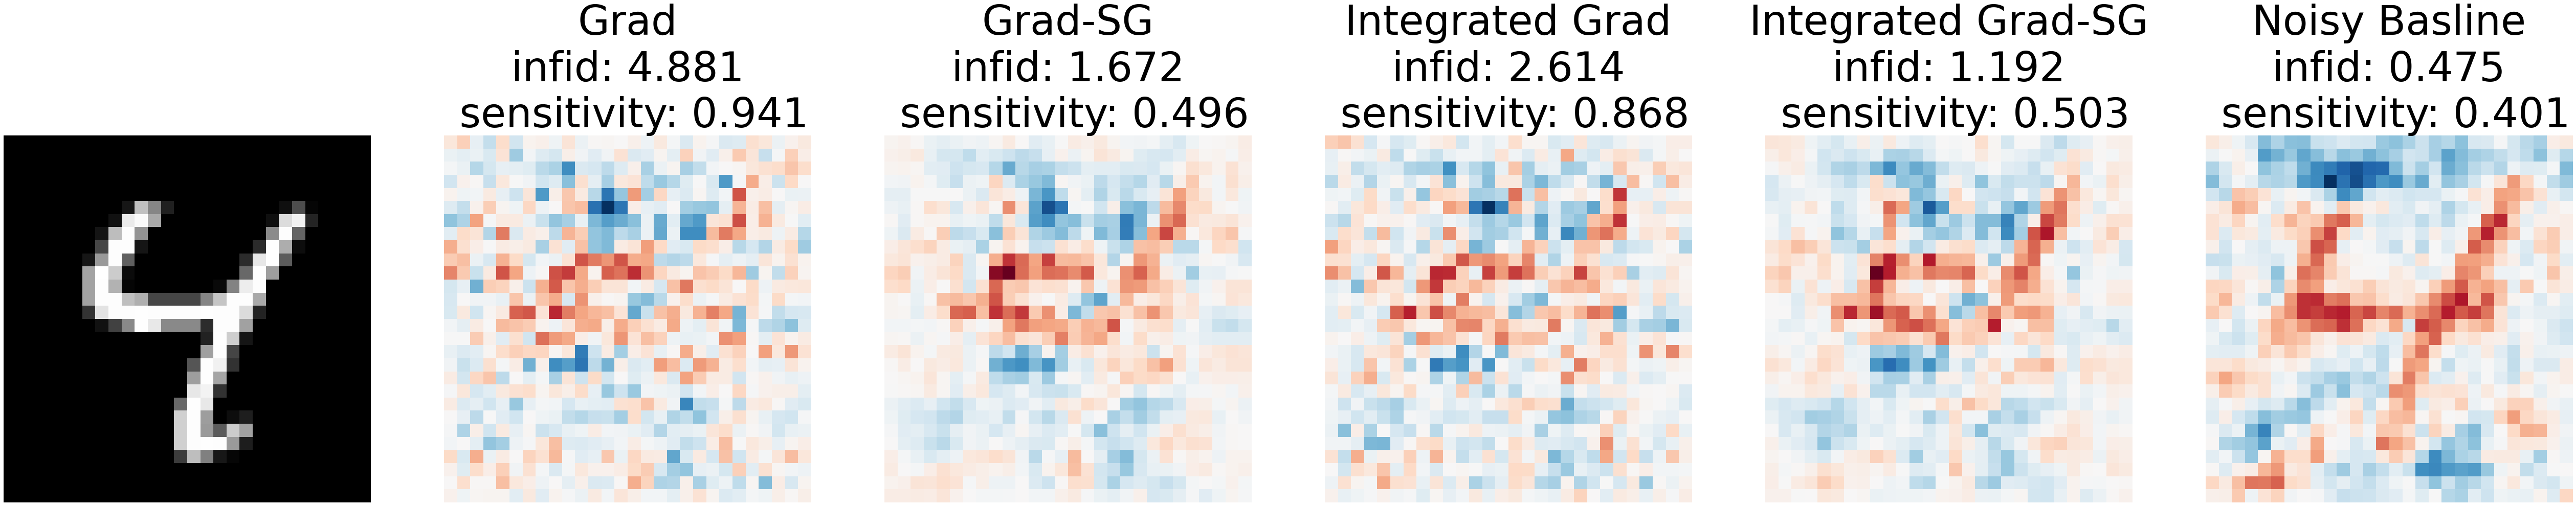

In [8]:
ind = 6 # change the index number to obtain results for other examples

X = Xs[ind]
y = ys[ind]
print(y.item())

n_cols = 6
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(15*6, 15*2))

ShowGrayscaleImageAxis(X.reshape(28, 28), ax=axes[0])

expl,infid,sens = get_expl_infid_sens(X, model, y, 'Grad', binary_I=False)
plot(vis(expl, True), axis=axes[1], title = 'Grad', infid = infid, sens = sens)

expl,infid,sens = get_expl_infid_sens(X, model, y, 'Smooth_Grad', sg_r=0.3, sg_N=50, given_expl='Grad', binary_I=False)
plot(vis(expl, True), axis=axes[2], title = 'Grad-SG', infid = infid, sens = sens)

expl,infid,sens = get_expl_infid_sens(X, model, y, 'Int_Grad', sg_r=0.3, sg_N=50, binary_I=False)
plot(vis(expl, True), axis=axes[3], title = 'Integrated Grad', infid = infid, sens = sens)

expl,infid,sens = get_expl_infid_sens(X, model, y, 'Smooth_Grad', sg_r=0.3, sg_N=50, given_expl='Int_Grad', binary_I=False)
plot(vis(expl, True), axis=axes[4], title = 'Integrated Grad-SG', infid = infid, sens = sens)

expl,infid,sens = get_expl_infid_sens(X, model, y, 'NB', sg_r=0.3, sg_N=50, binary_I=False)
expl = expl.reshape(1,28,28)
plot(vis(expl, True), axis=axes[5], title = 'Noisy Basline', infid = infid, sens = sens)

plt.show()